   - Sikeres konverzió! Adattípus: complex64
   - Beolvasott minták száma: 12288000
Radar Cube mérete: (4, 6000, 512)
   Formátum: (Antenna, Frame, FastTime Minta)


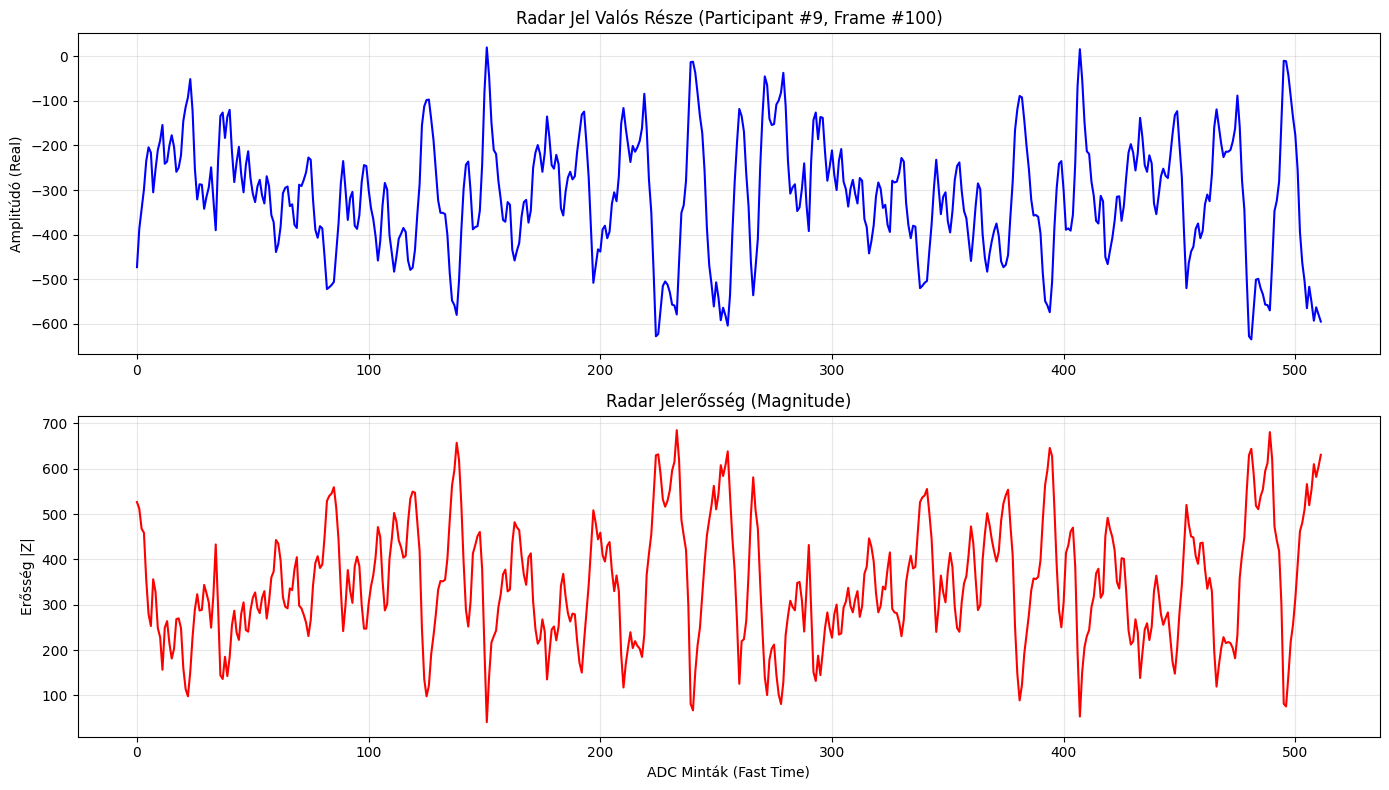

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


#RADAR PARAMÉTEREK (f_Parameter.m alapján)

RADAR_CONF = {
    'AntNum': 4,              # Antennák száma
    'adcsample': 256,         # Minták száma egy chirp-ben
    'chirploops': 2,          # Chirp-ek száma egy keretben
    'fps': 20,                # Frame per second
    'duration_min': 5,        # Mérés hossza (perc)
    # Származtatott érték:
    'datalength': 20 * 60 * 5 # 6000 Frame összesen
}

def load_radar_data(participant_num, base_path):
    filename = f'Rawdata_{participant_num}.csv'
    file_path = os.path.join(base_path, filename)
    
    if not os.path.exists(file_path):
        print(f"A fájl nem található ezen az útvonalon: {file_path}")
        return None

    
    try:
        
        with open(file_path, 'r') as f:
            raw_text = f.read()
            
        # 2. LÉPÉS: MATLAB 'i' cseréje Python 'j'-re
        # A radar adatok komplex számok (pl. 100+50i), de a Python a 'j'-t használja (100+50j)
        # A sortöréseket is vesszőre cseréljük a biztonság kedvéért
        raw_text = raw_text.replace('i', 'j').replace('\n', ',')
        
        str_values = [x for x in raw_text.split(',') if x.strip()]
        
        tstream = np.array(str_values, dtype=np.complex64)
        
        print(f"   - Sikeres konverzió! Adattípus: {tstream.dtype}")
        print(f"   - Beolvasott minták száma: {len(tstream)}")
        
    except Exception as e:
        print(f" Hiba a beolvasás/konverzió során: {e}")
        return None

    N_ant = RADAR_CONF['AntNum']
    total_samples = len(tstream)
    
    samples_per_ant = total_samples // N_ant
    
    # Egy frame mérete (FastTime * Chirps)
    samples_per_frame = RADAR_CONF['adcsample'] * RADAR_CONF['chirploops']
    num_frames = RADAR_CONF['datalength']
    
    # Biztonsági ellenőrzés: Megvan-e az elvárt adatmennyiség?
    expected_size = num_frames * samples_per_frame
    valid_length = min(samples_per_ant, expected_size)
    
    try:
        # Először szétbontjuk antennákra
        raw_data_by_ant = tstream.reshape((N_ant, samples_per_ant))
        
        # Levágjuk a felesleget, ha van
        raw_data_by_ant = raw_data_by_ant[:, :valid_length]
        
        # Végső 3D struktúra létrehozása: (Antenna, Frame, Minta)
        radar_cube = raw_data_by_ant.reshape(N_ant, num_frames, samples_per_frame)
        
        print(f"Radar Cube mérete: {radar_cube.shape}")
        print("   Formátum: (Antenna, Frame, FastTime Minta)")
        return radar_cube
        
    except ValueError as e:
        print(f"Hiba az adatok formázásakor (reshape): {e}")
        return None



PARTICIPANT_ID = 9
BASE_PATH = r"C:\Users\janko\Downloads\Children Dataset\Children Dataset\FMCW Radar\Rawdata" 

radar_data = load_radar_data(PARTICIPANT_ID, BASE_PATH)

if radar_data is not None:
    plt.figure(figsize=(14, 8))
    
    # Kiválasztjuk az 1. Antenna, 100. Frame adatait a példához
    # (Az első frame néha zajos, a 100. már stabilabb lehet)
    frame_idx = 100
    frame_data = radar_data[0, frame_idx, :]
    
    plt.subplot(2, 1, 1)
    plt.plot(np.real(frame_data), color='blue')
    plt.title(f"Radar Jel Valós Része (Participant #{PARTICIPANT_ID}, Frame #{frame_idx})")
    plt.ylabel("Amplitúdó (Real)")
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 1, 2)
    plt.plot(np.abs(frame_data), color='red')
    plt.title("Radar Jelerősség (Magnitude)")
    plt.xlabel("ADC Minták (Fast Time)")
    plt.ylabel("Erősség |Z|")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("Nem sikerült kirajzolni az adatokat a fenti hibák miatt.")

   - Max hatótáv (rangemax): 11.02 m
📏 Dinamikus küszöb: 6272
A gyerek 0.82 méterre van.


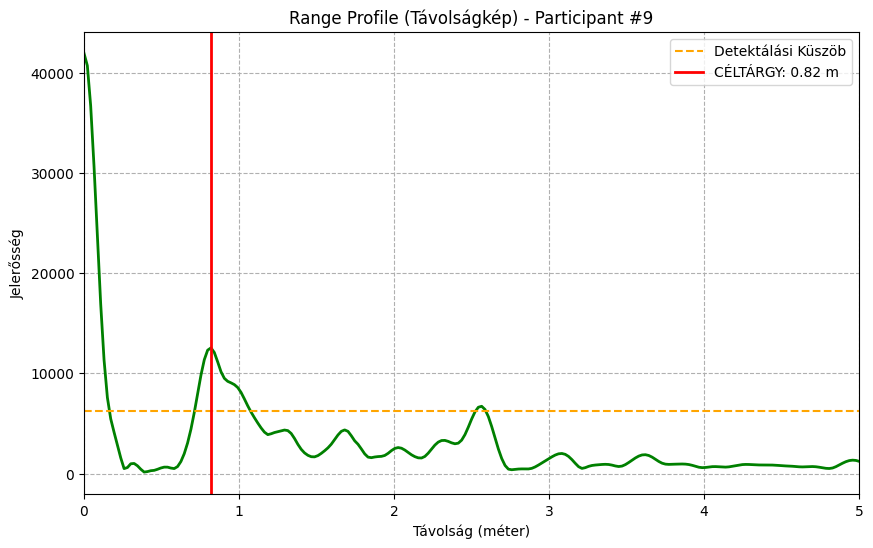

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

RADAR_CONF = {
    'AntNum': 4,
    'adcsample': 256,
    'chirploops': 2,
    'fps': 20,
    'duration_min': 5,
    'datalength': 20 * 60 * 5,
    
    'c': 3e8,                        # Fénysebesség
    'startfreq': 60.25e9,            # Kezdőfrekvencia
    'freqslope': 40.8450012207031251e12, # Meredekség (Slope)
    'samplerate': 3000e3,            # Mintavételezés (3 MHz)
    'bw': 3.746303561822511e9        # Sávszélesség
}

# Származtatott értékek számítása
RADAR_CONF['rangemax'] = (RADAR_CONF['samplerate'] * RADAR_CONF['c']) / (2 * RADAR_CONF['freqslope'])
RADAR_CONF['rangeresol'] = RADAR_CONF['c'] / (2 * RADAR_CONF['bw'])

print(f"   - Max hatótáv (rangemax): {RADAR_CONF['rangemax']:.2f} m")

# ==========================================
def compute_range_profile(radar_data_cube, conf):
    """
    Elvégzi a Range-FFT-t az adatokon.
    """
    samples_per_chirp = conf['adcsample']
    
    # Vesszük az 1. antenna összes frame-jének első chirp-jét
    raw_chirp1 = radar_data_cube[0, :, :samples_per_chirp] 
    
    # Ablakozás (Hanning ablak) a zajcsökkentéshez
    window = np.hanning(samples_per_chirp)
    raw_chirp1_windowed = raw_chirp1 * window
    
    # FFT számítás (Zero-padding a nagyobb felbontásért)
    fft_size = samples_per_chirp * 4 
    range_fft = np.fft.fft(raw_chirp1_windowed, n=fft_size, axis=1)
    
    # Csak a pozitív frekvenciafél megtartása
    range_fft = range_fft[:, :fft_size//2]
    
    return np.abs(range_fft), fft_size


# ==========================================

if 'radar_data' in locals() and radar_data is not None:
    
    # 1. FFT Profil kiszámítása
    range_profile, fft_size = compute_range_profile(radar_data, RADAR_CONF)

    # 2. Távolság tengely létrehozása
    max_range = RADAR_CONF['rangemax']
    freq_axis = np.linspace(0, max_range, fft_size//2)

    # 3. Átlagos profil (zajszűréshez)
    avg_range_profile = np.mean(range_profile, axis=0)

    # A. Keressük meg, hol kezdődik a 0.5 méter (hogy átugorjuk az antenna zaját)
    ignore_zone_idx = np.argmax(freq_axis > 0.5)

    # B. Keressük meg a maximumot CSAK a releváns zónában (0.5m után)
    max_val_in_target_zone = np.max(avg_range_profile[ignore_zone_idx:])

    # C. Állítsuk a küszöböt ennek a helyi maximumnek a felére (0.5)
    dynamic_threshold = max_val_in_target_zone * 0.5
    print(f"📏 Dinamikus küszöb: {dynamic_threshold:.0f}")

    # D. Keresés az új küszöbbel
    peaks, _ = find_peaks(avg_range_profile, height=dynamic_threshold)

    # E. Szűrés (csak ami távolabb van, mint 0.3m)
    valid_peaks = [p for p in peaks if freq_axis[p] > 0.3]

    plt.figure(figsize=(10, 6))
    plt.plot(freq_axis, avg_range_profile, color='green', linewidth=2)
    plt.title(f"Range Profile (Távolságkép) - Participant #{PARTICIPANT_ID}")
    plt.xlabel("Távolság (méter)")
    plt.ylabel("Jelerősség")
    plt.grid(True, which='both', linestyle='--')
    
    # Küszöb vonal kirajzolása
    plt.axhline(y=dynamic_threshold, color='orange', linestyle='--', label='Detektálási Küszöb')
    
    # Zoomoljunk a lényeges részre (0-5 méter)
    plt.xlim([0, 5])

    if len(valid_peaks) > 0:
        target_idx = valid_peaks[0] # Az első (legközelebbi) érvényes csúcs
        target_dist = freq_axis[target_idx]
        
        plt.axvline(x=target_dist, color='red', linestyle='-', linewidth=2, label=f'CÉLTÁRGY: {target_dist:.2f} m')
        plt.legend()
        
        print(f"A gyerek {target_dist:.2f} méterre van.")
        
        
        TARGET_DISTANCE = target_dist 
    else:
        plt.legend()

    plt.show()

else:
    print("Hiba: A 'radar_data' nincs betöltve! Futtasd le előbb a betöltő kódot.")

✅ Az előző lépésben talált távolságot használom: 0.819 m
🔍 Légzés keresése 0.819 méter távolságban...
   -> Ez a 38. indexű Range Bin.


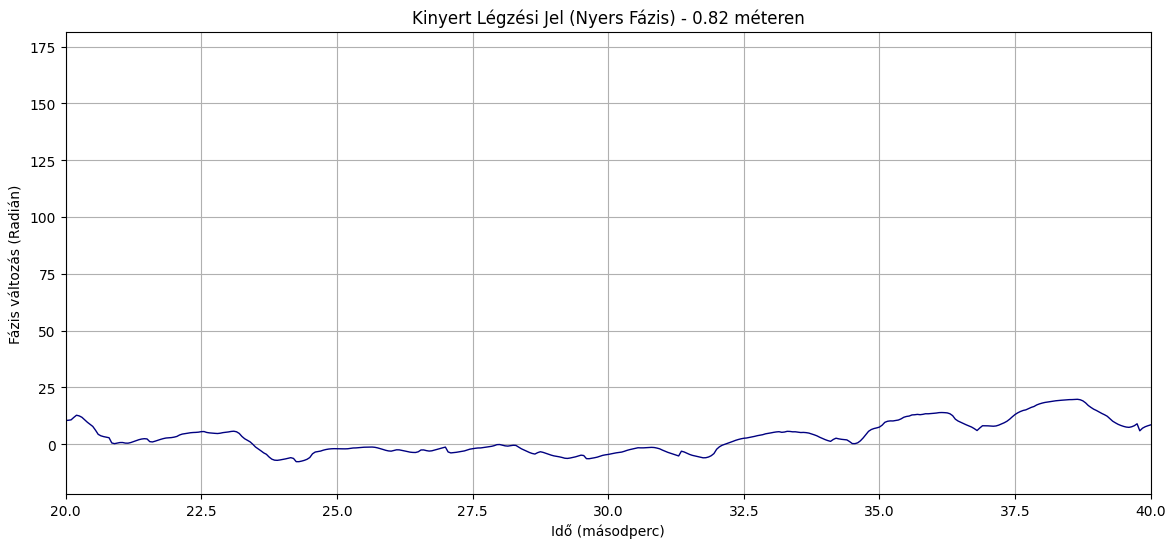

In [3]:

# ==========================================

def extract_breathing_signal(radar_cube, target_range_m, conf):
    """
    Kinyeri a fázis-információt (mozgást) a megadott távolságból.
    """
    print(f"🔍 Légzés keresése {target_range_m:.3f} méter távolságban...")
    
    # 1. Melyik index felel meg a távolságnak?
    samples_per_chirp = conf['adcsample']
    fft_size = samples_per_chirp * 4 
    range_res = conf['rangemax'] / (fft_size / 2)
    
    target_idx = int(target_range_m / range_res)
    print(f"   -> Ez a {target_idx}. indexű Range Bin.")
    
    # 2. Végigmegyünk az összes Frame-en és kivesszük ezt az egy pontot
    num_frames = radar_cube.shape[1]
    complex_signal = []
    
    # Ablakozás
    window = np.hanning(samples_per_chirp)
    
    for i in range(num_frames):
        # Kivesszük az 1. antenna, i. frame adatait
        raw_chirp = radar_cube[0, i, :samples_per_chirp]
        
        # Range-FFT
        fft_data = np.fft.fft(raw_chirp * window, n=fft_size)
        
        # Eltároljuk a céltárgy helyén lévő komplex számot
        complex_signal.append(fft_data[target_idx])
        
    complex_signal = np.array(complex_signal)
    
    # 3. Fázis kinyerése (Phase Extraction)
    raw_phase = np.angle(complex_signal)
    
    # 4. Kicsomagolás (Unwrapping)
    unwrapped_phase = np.unwrap(raw_phase)
    
    return unwrapped_phase

if 'TARGET_DISTANCE' in locals():
    print(f"✅ Az előző lépésben talált távolságot használom: {TARGET_DISTANCE:.3f} m")
    
    breathing_signal = extract_breathing_signal(radar_data, TARGET_DISTANCE, RADAR_CONF)

    plt.figure(figsize=(14, 6))

    time_axis = np.arange(len(breathing_signal)) / RADAR_CONF['fps']

    plt.plot(time_axis, breathing_signal, color='navy', linewidth=1)
    plt.title(f"Kinyert Légzési Jel (Nyers Fázis) - {TARGET_DISTANCE:.2f} méteren")
    plt.xlabel("Idő (másodperc)")
    plt.ylabel("Fázis változás (Radián)")
    plt.grid(True)

    # Zoomoljunk rá egy részletre, hogy lássuk a hullámzást
    plt.xlim([20, 40]) 

    plt.show()

else:
    print("A 'TARGET_DISTANCE' változó nincs definiálva!")

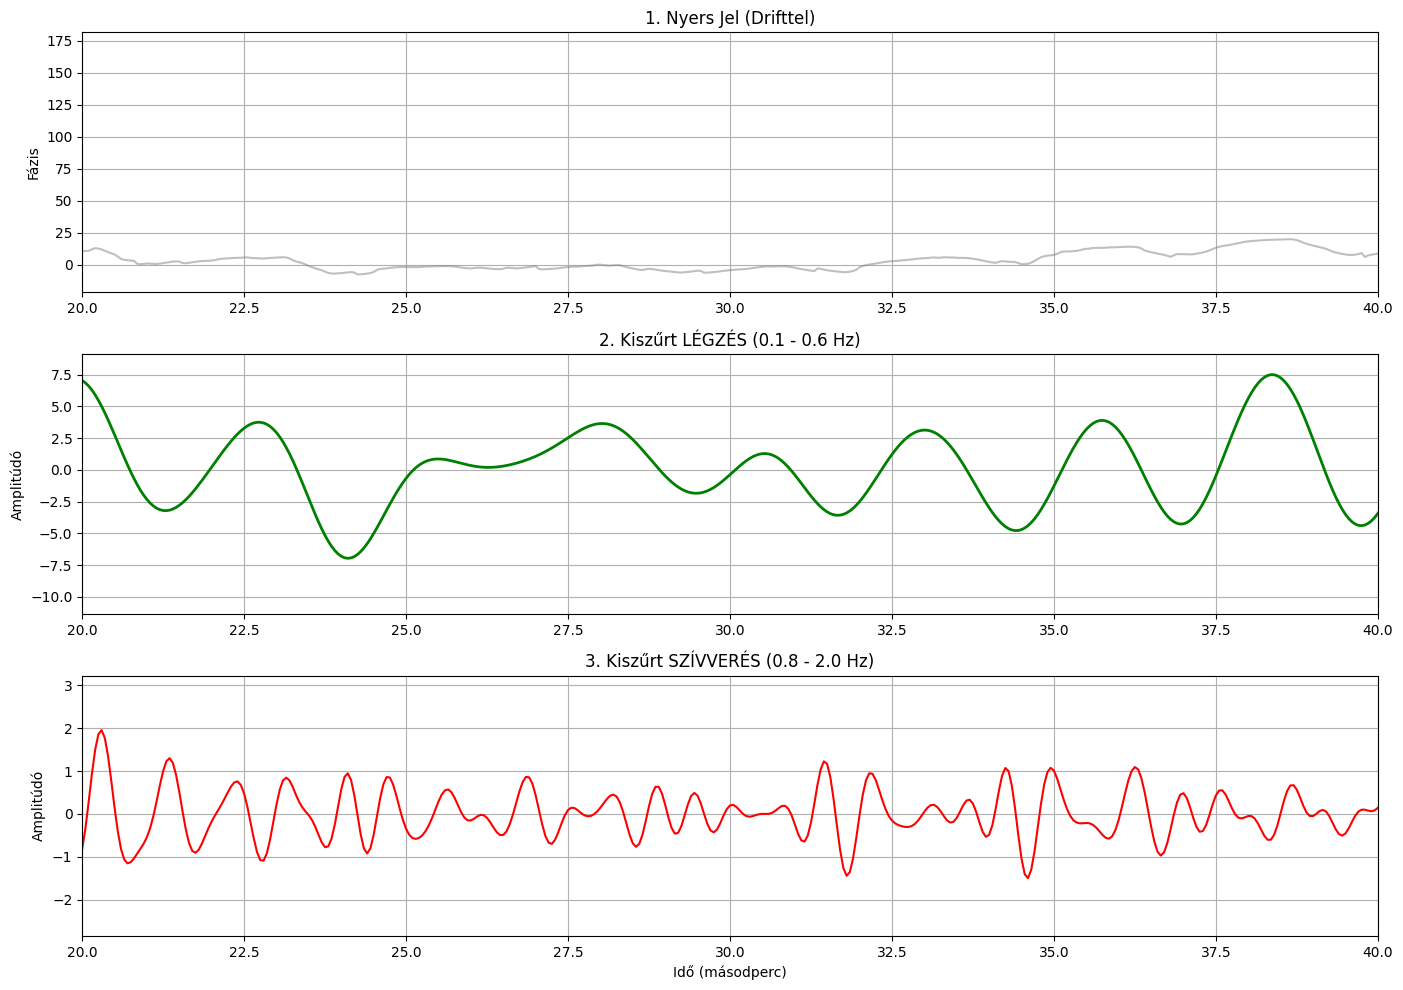

In [4]:
from scipy.signal import butter, filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Digitális sávszűrő (Butterworth).
    Csak a lowcut és highcut frekvenciák közötti jelet engedi át.
    """
    nyq = 0.5 * fs # Nyquist frekvencia
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data) # Zero-phase filtering (nem tolja el a fázist)
    return y

# Paraméterek a szűréshez
FPS = RADAR_CONF['fps']

# Emberi légzés: kb. 0.1 Hz (6 bpm) - 0.6 Hz (36 bpm)
breathing_filtered = butter_bandpass_filter(breathing_signal, 0.1, 0.6, FPS)

# Emberi szívverés: kb. 0.8 Hz (48 bpm) - 2.0 Hz (120 bpm)
heart_filtered = butter_bandpass_filter(breathing_signal, 0.8, 2.0, FPS)

plt.figure(figsize=(14, 10))

time_axis = np.arange(len(breathing_signal)) / FPS

# 1. Eredeti (Nyers)
plt.subplot(3, 1, 1)
plt.plot(time_axis, breathing_signal, color='gray', alpha=0.5, label='Nyers Fázis')
plt.title("1. Nyers Jel (Drifttel)")
plt.ylabel("Fázis")
plt.xlim([20, 40]) # Zoom
plt.grid(True)

# 2. Tisztított Légzés
plt.subplot(3, 1, 2)
plt.plot(time_axis, breathing_filtered, color='green', linewidth=2)
plt.title("2. Kiszűrt LÉGZÉS (0.1 - 0.6 Hz)")
plt.ylabel("Amplitúdó")
plt.xlim([20, 40]) # Zoom
plt.grid(True)

# 3. Tisztított Szívverés
plt.subplot(3, 1, 3)
plt.plot(time_axis, heart_filtered, color='red', linewidth=1.5)
plt.title("3. Kiszűrt SZÍVVERÉS (0.8 - 2.0 Hz)")
plt.xlabel("Idő (másodperc)")
plt.ylabel("Amplitúdó")
plt.xlim([20, 40]) # Zoom
plt.grid(True)

plt.tight_layout()
plt.show()

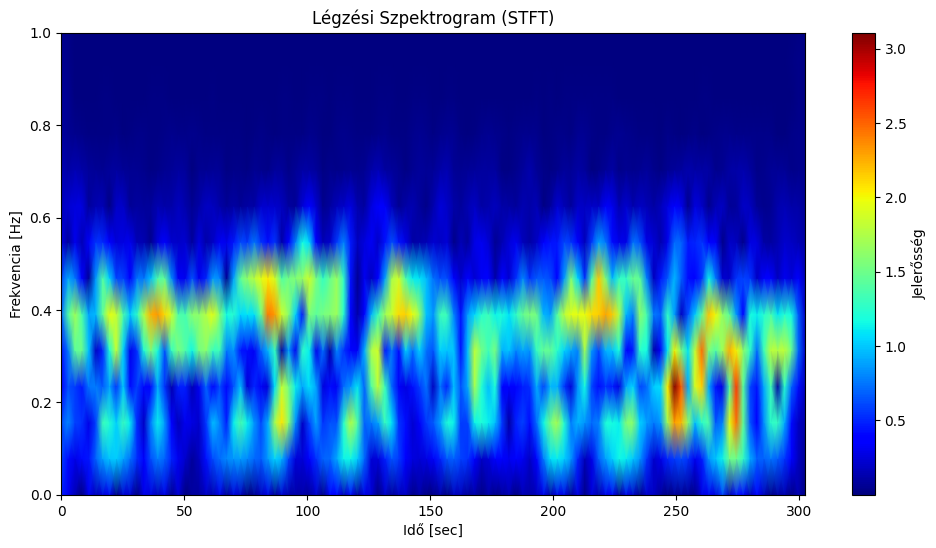

In [5]:
from scipy.signal import stft

def plot_spectrogram(phase_signal, fs):
    """
    Átalakítja az 1D fázisjelet 2D idő-frekvencia képpé (STFT).
    """
    # STFT paraméterek
    # nperseg: ablakméret. Nagyobb ablak = jobb frekvencia felbontás, de rosszabb időbeli.
    # A légzés lassú, ezért viszonylag nagy ablak kell.
    nperseg = 256  
    noverlap = 200 # Nagy átfedés a sima képért
    
    f, t, Zxx = stft(phase_signal, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)
    
    # Magnitudó (jelerősség) számítása
    spectrogram = np.abs(Zxx)
    
    plt.figure(figsize=(12, 6))
    
    plt.pcolormesh(t, f, spectrogram, shading='gouraud', cmap='jet')
    
    plt.title('Légzési Szpektrogram (STFT)')
    plt.ylabel('Frekvencia [Hz]')
    plt.xlabel('Idő [sec]')
    
    # Fókuszáljunk a légzés tartományára (0 - 1.0 Hz)
    plt.ylim([0, 1.0]) 
    
    # Színskála
    plt.colorbar(label='Jelerősség')
    
    plt.show()
    
    return f, t, spectrogram
freqs, times, spec_img = plot_spectrogram(breathing_filtered, FPS)

Légzés referencia fájl: C:\Users\janko\Downloads\Children Dataset\Children Dataset\Nihon Kohden\Heart Rate & Breathing Rate\Ref_Breath_9.csv
Referencia betöltve: 300 adatpont.


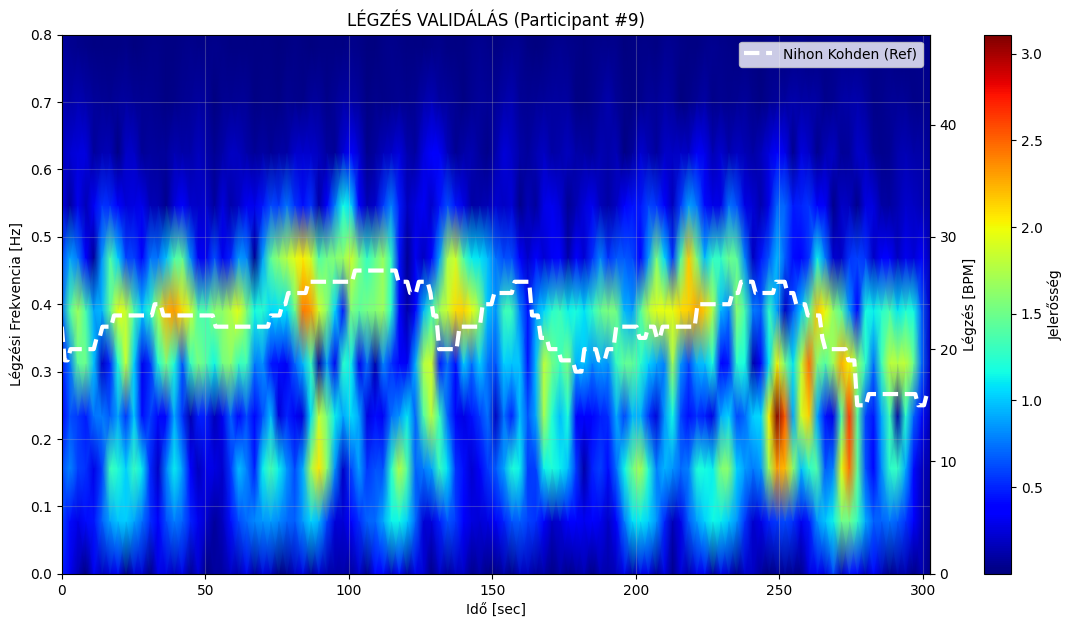

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft


def validate_breathing(participant_id, base_path, breathing_signal, fs):
    """
    1. Generál egy szpektrogramot a LÉGZÉS jelből.
    2. Betölti a Ref_Breath_X fájlt (CSV vagy XLSX).
    3. Összehasonlítja a kettőt.
    """
    
    root_dir = os.path.dirname(os.path.dirname(base_path))
    ref_dir = os.path.join(root_dir, "Nihon Kohden", "Heart Rate & Breathing Rate")
    
    file_candidates = [
        f"Ref_Breath_{participant_id}.csv",
        f"Ref_Breath_{participant_id}.xlsx"
    ]
    
    ref_file = None
    for fname in file_candidates:
        full_path = os.path.join(ref_dir, fname)
        if os.path.exists(full_path):
            ref_file = full_path
            break
            
    if ref_file is None:
        print(f"Nem találom a referencia fájlt (Ref_Breath_{participant_id}) a mappában!")
        print(f"   Keresési hely: {ref_dir}")
        return

    print(f"Légzés referencia fájl: {ref_file}")

    try:
        if ref_file.endswith('.csv'):
            # CSV esetén (egy sorban, vesszővel)
            with open(ref_file, 'r') as f:
                content = f.read().strip()
            ref_bpm = np.fromstring(content.replace('\n', ','), sep=',')
        else:
            # Excel esetén
            df = pd.read_excel(ref_file, header=None, engine='openpyxl')
            ref_bpm = df.values.flatten()
            
        print(f"Referencia betöltve: {len(ref_bpm)} adatpont.")
        
        # Átváltás Hz-be (BPM / 60)
        ref_hz = ref_bpm / 60.0
        
    except Exception as e:
        print(f"Hiba a fájl olvasásakor: {e}")
        return

    # FONTOS: Itt a 'breathing_filtered' jelet használjuk!
    nperseg = 256
    noverlap = 200 
    f, t, Zxx = stft(breathing_signal, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)
    spec_breath = np.abs(Zxx)

    plt.figure(figsize=(14, 7))
    
    plt.pcolormesh(t, f, spec_breath, shading='gouraud', cmap='jet') 
    plt.colorbar(label='Jelerősség')
    
    t_ref = np.linspace(0, t[-1], len(ref_hz))
    plt.plot(t_ref, ref_hz, color='white', linewidth=3, linestyle='--', label='Nihon Kohden (Ref)')


    plt.title(f"LÉGZÉS VALIDÁLÁS (Participant #{participant_id})")
    plt.ylabel("Légzési Frekvencia [Hz]")
    plt.xlabel("Idő [sec]")
    
    # Fókuszáljunk a LÉGZÉS tartományára (0.1 Hz - 0.8 Hz -> 6 - 48 BPM)
    plt.ylim([0.0, 0.8]) 
    
    # Segédvonalak BPM-ben a jobb oldalon
    secax = plt.gca().secondary_yaxis('right', functions=(lambda x: x*60, lambda x: x/60))
    secax.set_ylabel('Légzés [BPM]')

    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

if 'breathing_filtered' in locals():
    validate_breathing(PARTICIPANT_ID, BASE_PATH, breathing_filtered, RADAR_CONF['fps'])
else:
    print("Hiba")

Referencia fájl: C:\Users\janko\Downloads\Children Dataset\Children Dataset\Nihon Kohden\Heart Rate & Breathing Rate\Ref_Heart_9.csv
✅ Referencia betöltve: 300 adatpont.
   Első 5 érték (BPM): [87. 83. 83. 84. 84.]


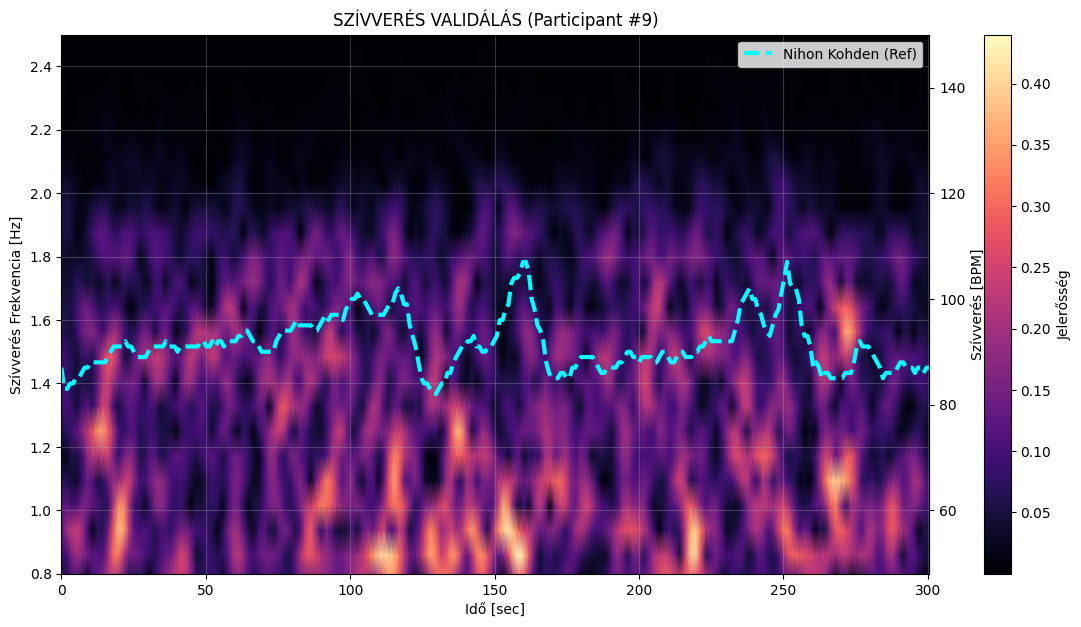

In [7]:

def validate_heart_rate(participant_id, base_path, heart_signal, fs):
    """
    1. Generál egy szpektrogramot a szívverés jelből.
    2. Betölti a Ref_Heart_X.csv fájlt.
    3. Összehasonlítja a kettőt.
    """
    
    root_dir = os.path.dirname(os.path.dirname(base_path))
    ref_file = os.path.join(root_dir, "Nihon Kohden", "Heart Rate & Breathing Rate", f"Ref_Heart_{participant_id}.csv")
    
    print(f"Referencia fájl: {ref_file}")
    
    if not os.path.exists(ref_file):
        print("Nem találom a referencia fájlt! Ellenőrizd az útvonalat.")
        return

    try:
        with open(ref_file, 'r') as f:
            content = f.read().strip()
            
        ref_bpm = np.fromstring(content.replace('\n', ','), sep=',')
        
        print(f"✅ Referencia betöltve: {len(ref_bpm)} adatpont.")
        print(f"   Első 5 érték (BPM): {ref_bpm[:5]}")
        
        ref_hz = ref_bpm / 60.0
        
    except Exception as e:
        print(f"Hiba a CSV olvasásakor: {e}")
        return

    nperseg = 256
    noverlap = 220
    f, t, Zxx = stft(heart_signal, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)
    spec_heart = np.abs(Zxx)

    plt.figure(figsize=(14, 7))
    
    
    plt.pcolormesh(t, f, spec_heart, shading='gouraud', cmap='magma') 
    plt.colorbar(label='Jelerősség')
    
    t_ref = np.linspace(0, t[-1], len(ref_hz))
    plt.plot(t_ref, ref_hz, color='cyan', linewidth=3, linestyle='--', label='Nihon Kohden (Ref)')

    plt.title(f"SZÍVVERÉS VALIDÁLÁS (Participant #{participant_id})")
    plt.ylabel("Szívverés Frekvencia [Hz]")
    plt.xlabel("Idő [sec]")
    
    # Fókuszáljunk a szívverés tartományára (0.8 Hz - 2.5 Hz -> 48 - 150 BPM)
    plt.ylim([0.8, 2.5]) 
    
    # Segédvonalak BPM-ben a jobb oldalon (opcionális, de profi)
    secax = plt.gca().secondary_yaxis('right', functions=(lambda x: x*60, lambda x: x/60))
    secax.set_ylabel('Szívverés [BPM]')

    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()


validate_heart_rate(PARTICIPANT_ID, BASE_PATH, heart_filtered, RADAR_CONF['fps'])